In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import OrderedDict

In [2]:
from dataloader import read_bci_data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
# Load data
train_data, train_label, test_data, test_label = read_bci_data()

# Convert data type into float32
train_data  = torch.from_numpy(train_data).type(torch.float32)
train_label = torch.from_numpy(train_label).type(torch.long)
test_data   = torch.from_numpy(test_data).type(torch.float32)
test_label  = torch.from_numpy(test_label).type(torch.long)

(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)


## Implement EEGNet

In [4]:
from EEGNet import EEGNet

# Run Model

In [5]:
from run_model import run, draw_figure
line_list = []
label_list = ['elu_train','elu_test','leaky_relu_train','leaky_relu_test','relu_train','relu_test']

# ELU
net = EEGNet().to(device)
loss_list, acc_train_list, acc_test_list = run(net, train_data,train_label,test_data,test_label\
                                               , num_epochs = 300, batch_size = 64, print_freq = 301)
line_list.append(acc_train_list)
line_list.append(acc_test_list)

# Leaky_relu
net = EEGNet(act_f='leakyrelu').to(device)
loss_list, acc_train_list, acc_test_list = run(net, train_data,train_label,test_data,test_label\
                                               , num_epochs = 300, batch_size = 64, print_freq = 301)
line_list.append(acc_train_list)
line_list.append(acc_test_list)

# Relu
net = EEGNet(act_f='relu').to(device)
loss_list, acc_train_list, acc_test_list = run(net, train_data,train_label,test_data,test_label\
                                               ,num_epochs = 300, batch_size = 64, print_freq = 301)
line_list.append(acc_train_list)
line_list.append(acc_test_list)

# Draw loss & accuracy figures

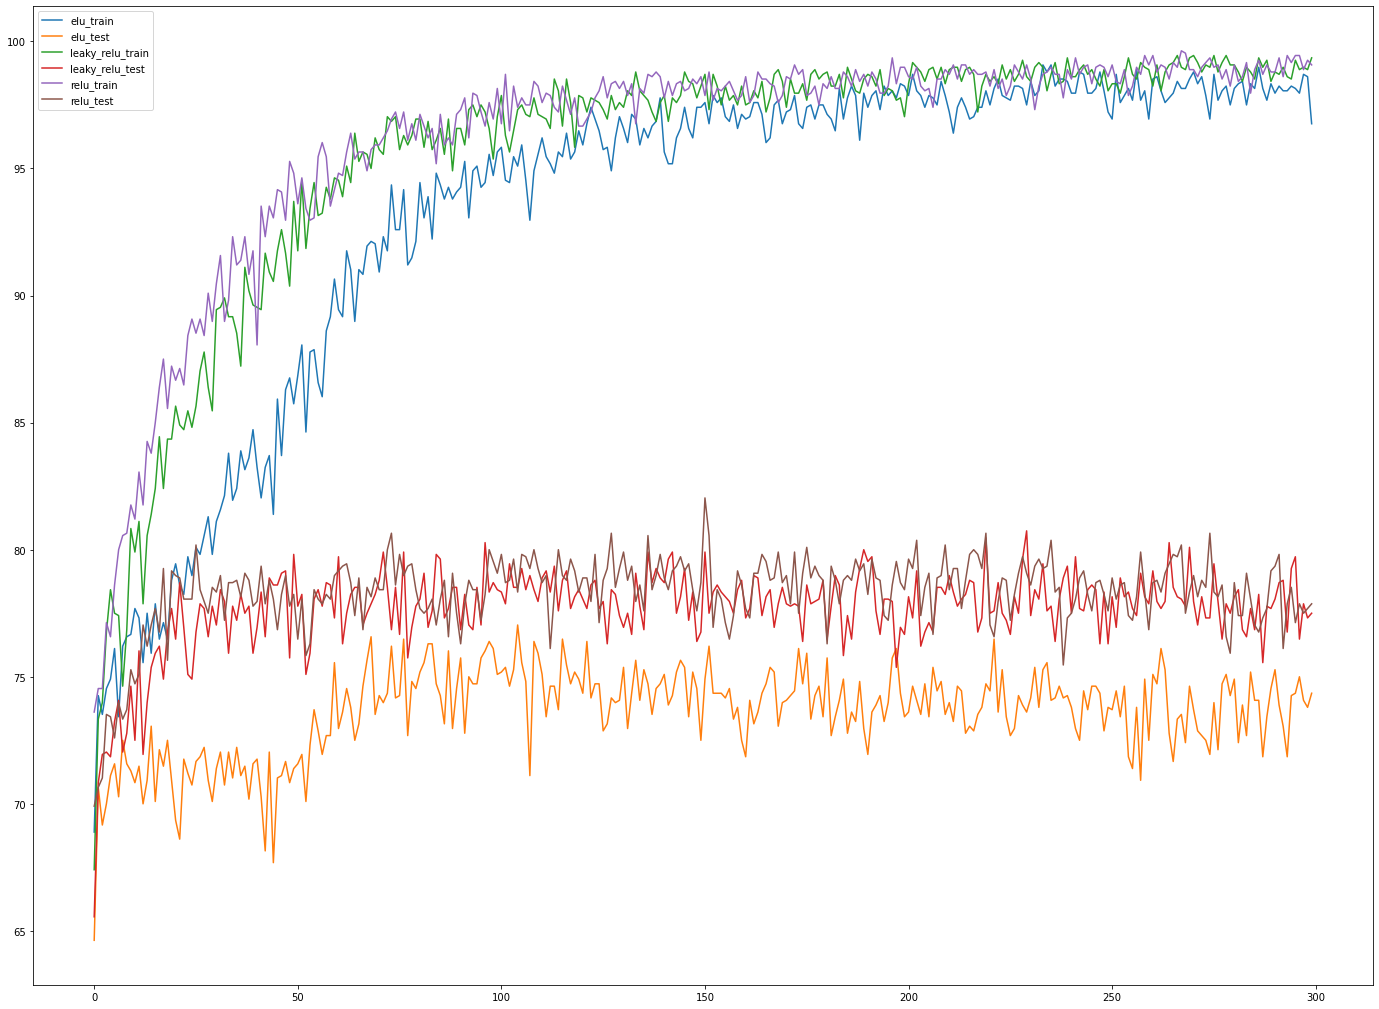

In [6]:
plt.figure(figsize=[24,18])
draw_figure(plt,line_list,label_list, loc='best')

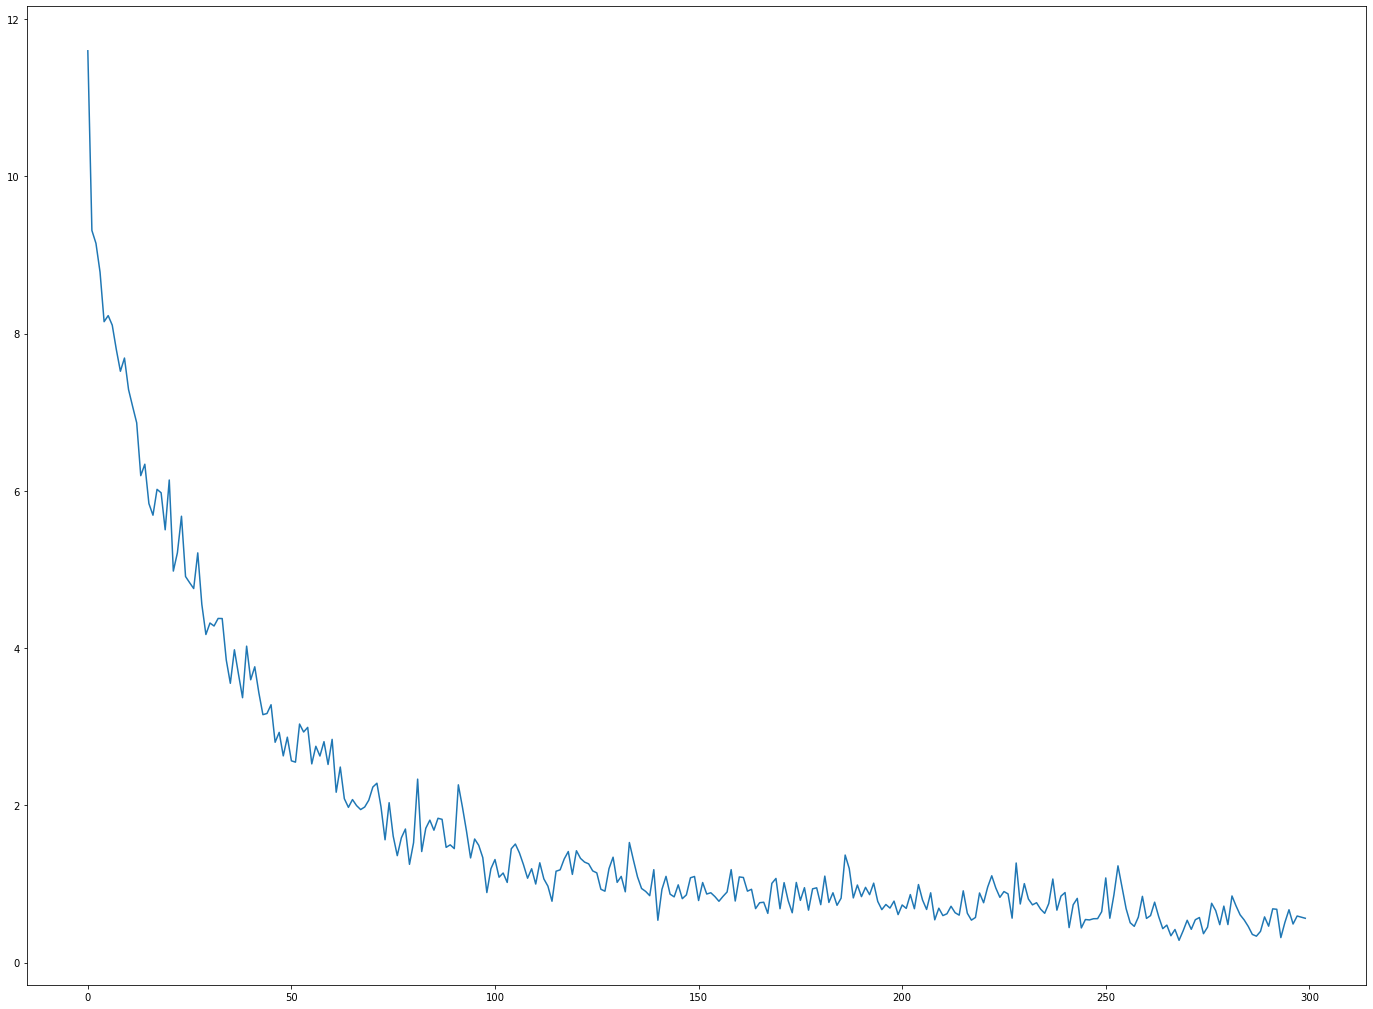

In [7]:
plt.figure(figsize=[24,18])
draw_figure(plt,[loss_list])

In [23]:

C = 2
T = 750
a = torch.randn(C,T)

In [24]:
a

tensor([[-0.1981, -0.4735, -0.2250,  ..., -1.4685,  1.1196,  0.2486],
        [ 0.6894,  0.2797, -0.4440,  ...,  1.2385, -1.7305,  0.1302]])

In [26]:
a.view(1,C,T)

tensor([[[-0.1981, -0.4735, -0.2250,  ..., -1.4685,  1.1196,  0.2486],
         [ 0.6894,  0.2797, -0.4440,  ...,  1.2385, -1.7305,  0.1302]]])

## Implement DeepConvNet

In [27]:
class DeepConvNet(nn.Sequential):
    def __init__(self,act_f = 'elu',*args, **kwargs):
        act_f_list = {'elu':nn.ELU,
                      'leakyrelu':nn.LeakyReLU,
                      'relu': nn.ReLU,
                      'prelu':nn.PReLU
                     }
        self.C = 2
        self.T = 750
        
        ### Layer 1
        firstConv = nn.Sequential(
            nn.Conv2d(1,25,kernel_size=(1,5)),
            nn.Conv2d(25,25,kernel_size=(self.C,1)),
            nn.BatchNorm2d(2*25),
            act_f_list[act_f](*args, **kwargs),# Activation function
            nn.MaxPool2d((1,2)),
            nn.Dropout2d()
        )
        
        ### Layer 2
        secondConv = nn.Sequential(
            nn.Conv2d(25,50,kernel_size=(1,5)),
            nn.BatchNorm2d(2*50),
            act_f_list[act_f](*args, **kwargs),# Activation function
            nn.MaxPool2d((1,2)),
            nn.Dropout2d()
        )
        
        ### Layer 3
        thirdConv = nn.Sequential(
            nn.Conv2d(50,100,kernel_size=(1,5)),
            nn.BatchNorm2d(2*100),
            act_f_list[act_f](*args, **kwargs),# Activation function
            nn.MaxPool2d((1,2)),
            nn.Dropout2d()
        )
        
        ### Layer 4
        fourthConv = nn.Sequential(
            nn.Conv2d(100,200,kernel_size=(1,5)),
            nn.BatchNorm2d(2*200),
            act_f_list[act_f](*args, **kwargs),# Activation function
            nn.MaxPool2d((1,2)),
            nn.Dropout2d(),
            nn.Flatten()
        )
        
        ### Fully connected layer
        classify = nn.Sequential(
            nn.Linear(in_features=736, out_features=2, bias=True)
        )
        super(DeepConvNet, self).__init__(OrderedDict([
                  ('firstConv' , firstConv),
                  ('secondConv', secondConv),
                  ('thirdConv' , thirdConv),
                  ('fourthConv', fourthConv),
                  ('classify'  , classify)
                ]))
        
    def forward(self,x):
        x = super(DeepConvNet,self).forward(x)
        return x
    
    def infer_and_cal_acc(self,x,ground_truth):
        # Run self.forward(x) and calculate accuracy with ground_truth
        
        y = self.forward(x)
        # Get the calssification result of y,
        # because y has 2 channels for each class
        _, y_hat = torch.max(y,1)
        # Calculate accuracy
        acc = 100*(len(ground_truth[ground_truth==y_hat])/len(ground_truth))
        return acc
        